In [10]:
# ----------------------
# Step 1: Import Libraries
# ----------------------
import tensorflow as tf

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
import numpy as np

import pickle

import os

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_extract, col

In [35]:
current_directory = os.getcwd().replace('\\', '/')
print(current_directory)

d:/GIT/big_data-proj/big-data-framework-proj


In [16]:
# ----------------------
# Step 2: Spark Steps
# ----------------------

# Initialize Spark Session
# Spark is used to handle and preprocess large datasets in a distributed manner.
spark = SparkSession.builder \
    .appName("SparkWithFlowFromDirectory") \
    .master("local[*]") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()






In [36]:
# Step 1: Load images using Spark
# Spark reads all image files in the specified path and loads metadata such as file path and content.
image_df = spark.read.format("binaryFile").load("archive/Train/*/*.jpg")
image_df


DataFrame[path: string, modificationTime: timestamp, length: bigint, content: binary]

In [30]:
image_df.show(5, truncate=False)

+------------------------------------------------------------------------------+-------------------+------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [37]:
from pyspark.sql.functions import regexp_replace

# replace all path column with the current directory
image_df = image_df.withColumn(
    "path", regexp_replace(image_df.path, current_directory, 'content')
)

In [38]:
image_df.show(5, truncate=False)

+-----------------------------------------+-------------------+------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [39]:
# Step 2: Extract labels (class names) from folder names
# The "label" is extracted from the folder structure using a regular expression.
# For example: 'archive/Train/A/1000_A.jpg' → label: 'A'
image_df = image_df.withColumn(
    "label", regexp_extract(col("path"), r"/([^/]+)/[^/]+$", 1)  # Extract folder names as labels
)


In [40]:

# Step 3: Display a sample of the data to verify paths and labels
# This helps ensure that paths and labels were extracted correctly.
image_df.select("path", "label").show(5, truncate=False)

+-----------------------------------------+-----+
|path                                     |label|
+-----------------------------------------+-----+
|file:/content/archive/Train/H/9162_H.jpg |H    |
|file:/content/archive/Train/H/11135_H.jpg|H    |
|file:/content/archive/Train/H/3250_H.jpg |H    |
|file:/content/archive/Train/H/4494_H.jpg |H    |
|file:/content/archive/Train/H/23625_H.jpg|H    |
+-----------------------------------------+-----+
only showing top 5 rows



In [41]:
# Step 4: Validate image paths
# Check for invalid or missing files (e.g., paths that don't start with "file:").
invalid_files = image_df.filter(~col("path").startswith("file:"))
invalid_files.show()  # Show invalid files (if any)




+----+----------------+------+-------+-----+
|path|modificationTime|length|content|label|
+----+----------------+------+-------+-----+
+----+----------------+------+-------+-----+



In [42]:
# Step 5: Count the number of images per label
# Helps check if there are any class imbalances in the dataset.
label_counts = image_df.groupBy("label").count()
label_counts.show()

+-----+-----+
|label|count|
+-----+-----+
|    O| 1196|
|    A| 1126|
|    G| 1090|
|    H| 1013|
|    Q| 1279|
|    Y| 1118|
|    L| 1241|
|    M| 1055|
|    C| 1144|
|    N| 1151|
|    F| 1204|
|    E|  957|
|    W| 1225|
|    P| 1088|
|    X| 1164|
|    B| 1010|
|    V| 1082|
|    S| 1199|
|    T| 1186|
|    U| 1161|
+-----+-----+
only showing top 20 rows



In [47]:
# Step 6: Save the processed metadata as a single CSV file
# This CSV contains the paths and labels for all valid images in the dataset.
# `coalesce(1)` ensures that the output is saved as a single CSV file.
image_df.select("path", "label") \
    .coalesce(1) \
    .write.csv("validated_metadata", header=True, mode="overwrite")




In [48]:
# Step 7: Rename the generated CSV file for easier access
# Spark saves the CSV as "part-xxxxx" files inside a folder, so we rename it to a single file.
import os

for file in os.listdir("validated_metadata"):
    if file.startswith("part-00000-"):
        os.rename(os.path.join("validated_metadata", file), "validated_metadata_single.csv")



# !move validated_metadata.csv/part-00000-*.csv validated_metadata_single.csv

In [3]:
# Step 8: Load the CSV into Pandas
# Use Pandas to read the metadata file for further preprocessing with TensorFlow/Keras.
import pandas as pd
train_metadata = pd.read_csv("validated_metadata_single.csv")

# Step 9: Adjust file paths for compatibility with Keras
# Remove the "file:" prefix and adjust the base path to match the local directory structure.
train_metadata["path"] = train_metadata["path"].str.replace("file:", "", regex=False)
train_metadata["path"] = train_metadata["path"].str.replace("/content/", "", regex=False)

# Step 10: Verify the updated paths
# Check the first few rows to confirm that paths and labels are correct.
print(train_metadata.head())


                          path label
0   archive/Train/H/9162_H.jpg     H
1  archive/Train/H/11135_H.jpg     H
2   archive/Train/H/3250_H.jpg     H
3   archive/Train/H/4494_H.jpg     H
4  archive/Train/H/23625_H.jpg     H


In [4]:
# Step 11: Preprocess Training Data with Keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create the ImageDataGenerator for data augmentation and preprocessing
# This applies transformations like rotation, zoom, and flipping to increase dataset variability.
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Normalize pixel values to [0, 1]
    rotation_range=30,         # Random rotation up to 30 degrees
    width_shift_range=0.2,     # Random horizontal shift
    height_shift_range=0.2,    # Random vertical shift
    brightness_range=[0.8, 1.2],  # Random brightness adjustment
    horizontal_flip=True,      # Random horizontal flipping
    zoom_range=0.2             # Random zoom
)




In [5]:
# Load the images and labels from the DataFrame
# Keras uses the paths and labels to dynamically load and preprocess images.
training_set = train_datagen.flow_from_dataframe(
    dataframe=train_metadata,  # Pandas DataFrame containing paths and labels
    x_col="path",              # Column containing image file paths
    y_col="label",             # Column containing class labels
    target_size=(128, 128),    # Resize all images to 128x128
    batch_size=64,             # Number of images per batch
    class_mode="sparse",       # Sparse labels (integers) for multi-class classification
    color_mode="rgb",          # Load RGB images
    shuffle=True               # Shuffle the data for training
)

Found 27455 validated image filenames belonging to 24 classes.


In [11]:
class_indices = training_set.class_indices  # Get the class label-to-index mapping
with open('class_indices.pkl', 'wb') as f:
    pickle.dump(class_indices, f)  # Save the mapping to a file

print("Class indices saved successfully:", class_indices)

Class indices saved successfully: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'O': 13, 'P': 14, 'Q': 15, 'R': 16, 'S': 17, 'T': 18, 'U': 19, 'V': 20, 'W': 21, 'X': 22, 'Y': 23}


In [54]:
# Step 12: Process the Test Data
# Load test images using Spark
test_image_df = spark.read.format("binaryFile").load("archive/Test/*/*.jpg")

# Extract labels for the test set from folder names
test_image_df = test_image_df.withColumn(
    "label", regexp_extract(col("path"), r"/([^/]+)/[^/]+$", 1)
)



In [55]:
# replace all path column with the current directory
test_image_df = test_image_df.withColumn(
    "path", regexp_replace(test_image_df.path, current_directory, 'content')
)

In [56]:
# Save test metadata to a CSV file
test_image_df.select("path", "label").coalesce(1).write.csv("test_metadata", header=True, mode="overwrite")




In [57]:
test_image_df.select("path", "label").show(5, truncate=False)

+---------------------------------------+-----+
|path                                   |label|
+---------------------------------------+-----+
|file:/content/archive/Test/H/6488_H.jpg|H    |
|file:/content/archive/Test/H/4388_H.jpg|H    |
|file:/content/archive/Test/H/2049_H.jpg|H    |
|file:/content/archive/Test/H/1246_H.jpg|H    |
|file:/content/archive/Test/H/5202_H.jpg|H    |
+---------------------------------------+-----+
only showing top 5 rows



In [59]:
# Rename the partitioned CSV file to a single file

# Step 7: Rename the generated CSV file for easier access
# Spark saves the CSV as "part-xxxxx" files inside a folder, so we rename it to a single file.
import os

for file in os.listdir("test_metadata"):
    if file.startswith("part-00000-"):
        os.rename(os.path.join("test_metadata", file), "test_metadata_single.csv")



# !mv test_metadata.csv/part-00000-*.csv test_metadata_single.csv

In [60]:
# Step 13: Load Test Metadata into Pandas
# Use Pandas to load the metadata for the test set
test_metadata = pd.read_csv("test_metadata_single.csv")

# Adjust file paths for Keras compatibility
test_metadata["path"] = test_metadata["path"].str.replace("file:", "", regex=False)
test_metadata["path"] = test_metadata["path"].str.replace("/content/", "", regex=False)

# Verify the updated paths
print(test_metadata.head())


                        path label
0  archive/Test/H/6488_H.jpg     H
1  archive/Test/H/4388_H.jpg     H
2  archive/Test/H/2049_H.jpg     H
3  archive/Test/H/1246_H.jpg     H
4  archive/Test/H/5202_H.jpg     H


In [61]:
# Step 14: Preprocess Test Data with Keras
# Test set typically only requires rescaling (no augmentation).
test_datagen = ImageDataGenerator(rescale=1./255)

# Load test images and labels from the DataFrame
test_set = test_datagen.flow_from_dataframe(
    dataframe=test_metadata,  # Pandas DataFrame containing paths and labels
    x_col="path",             # Column containing image file paths
    y_col="label",            # Column containing class labels
    target_size=(128, 128),   # Resize images to 128x128
    batch_size=64,            # Batch size
    class_mode="sparse",      # Sparse labels
    color_mode="rgb",         # Load RGB images
    shuffle=False             # Do not shuffle test data for evaluation
)


Found 7172 validated image filenames belonging to 24 classes.


In [62]:
x_batch, y_batch = next(training_set) 
x_batch, y_batch 

(array([[[[0.63529414, 0.63529414, 0.63529414],
          [0.63529414, 0.63529414, 0.63529414],
          [0.63529414, 0.63529414, 0.63529414],
          ...,
          [0.6627451 , 0.6627451 , 0.6627451 ],
          [0.6627451 , 0.6627451 , 0.6627451 ],
          [0.6627451 , 0.6627451 , 0.6627451 ]],
 
         [[0.63529414, 0.63529414, 0.63529414],
          [0.63529414, 0.63529414, 0.63529414],
          [0.63529414, 0.63529414, 0.63529414],
          ...,
          [0.6627451 , 0.6627451 , 0.6627451 ],
          [0.6627451 , 0.6627451 , 0.6627451 ],
          [0.6627451 , 0.6627451 , 0.6627451 ]],
 
         [[0.63529414, 0.63529414, 0.63529414],
          [0.63529414, 0.63529414, 0.63529414],
          [0.63529414, 0.63529414, 0.63529414],
          ...,
          [0.6627451 , 0.6627451 , 0.6627451 ],
          [0.6627451 , 0.6627451 , 0.6627451 ],
          [0.6627451 , 0.6627451 , 0.6627451 ]],
 
         ...,
 
         [[0.5686275 , 0.5686275 , 0.5686275 ],
          [0.56862

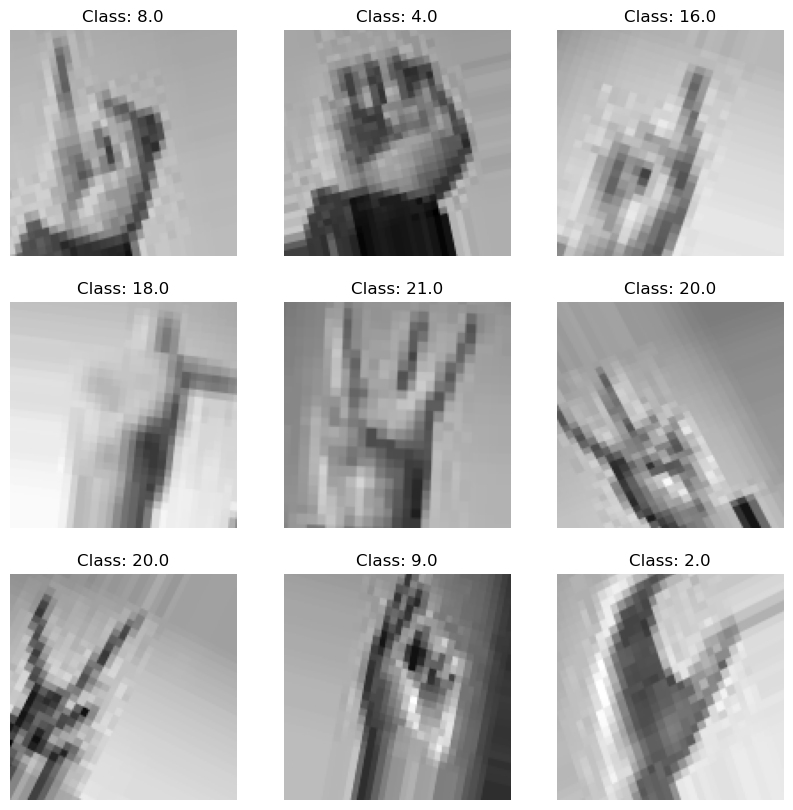

In [65]:
# Display some augmented images
x_batch, y_batch = next(training_set)  # Get a batch of training data
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i].squeeze(), cmap='gray')  # Use `cmap='gray'` for grayscale
    plt.title(f'Class: {y_batch[i]}')  # Sparse labels are integers
  # Adjust title for one-hot or sparse
    plt.axis('off')
plt.show()


In [66]:
# ----------------------
# Step 3: Load Pretrained Model (Feature Extractor)
# ----------------------

# Load MobileNetV2 pretrained on ImageNet
base_model = MobileNetV2(
    input_shape=(128, 128, 3),  # MobileNetV2 expects 3-channel RGB input
    include_top=False,          # Exclude the classification head
    weights='imagenet'          # Use pretrained weights
)

# Freeze the base model's layers to prevent training
base_model.trainable = False


In [67]:
# ----------------------
# Step 4: Build the Model
# ----------------------

# Add custom layers on top of the pretrained base model
model = Sequential([

    # Use the pretrained base model as a fixed feature extractor
    base_model,  # Pretrained MobileNetV2 without the classification head
    GlobalAveragePooling2D(),  # Replace Flatten with GAP to reduce overfitting

    # Custom dense layers for classification
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),  # Dropout to prevent overfitting
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout to prevent overfitting
    Dense(24, activation='softmax')  # 24 classes for ASL
])



In [68]:
# ----------------------
# Step 5: Compile the Model
# ----------------------

model.compile(
    optimizer=Adam(learning_rate=0.00001),  # Lower learning rate for stability
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [69]:
# Inspect a batch of data from the generator
x_batch, y_batch = next(training_set)
print("Input batch shape (x_batch):", x_batch.shape)
print("Label batch shape (y_batch):", y_batch.shape)
training_set.reset()
test_set.reset()

y_batch = np.argmax(y_batch, axis=-1)


Input batch shape (x_batch): (64, 128, 128, 3)
Label batch shape (y_batch): (64,)


In [70]:
# ----------------------
# Step 6: Train the Model
# ----------------------

# model_checkpoint = ModelCheckpoint(
#     'best_model.h5',
#     monitor='val_loss',
#     save_best_only=True,
#     mode='min'
# )

reduce_lr = ReduceLROnPlateau( # Dynamic adjustment of the learning rate during training can lead to better convergence.
    monitor='val_loss',
    factor=0.5,   # Reduce the learning rate by half
    patience=3,   # If no improvement for 3 epochs
    min_lr=1e-6   # Set a minimum learning rate
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    training_set,
    validation_data=test_set,
    epochs=25,
    # class_weight = class_weights,
    callbacks=[reduce_lr, early_stopping]
)

C:\Users\alber\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
429/429 ━━━━━━━━━━━━━━━━━━━━ 125s 281ms/step - accuracy: 0.0439 - loss: 4.8361 - val_accuracy: 0.0627 - val_loss: 3.2410 - learning_rate: 1.0000e-05
Epoch 2/25
429/429 ━━━━━━━━━━━━━━━━━━━━ 87s 203ms/step - accuracy: 0.0625 - loss: 4.3806 - val_accuracy: 0.1107 - val_loss: 3.0033 - learning_rate: 1.0000e-05
Epoch 3/25
429/429 ━━━━━━━━━━━━━━━━━━━━ 89s 207ms/step - accuracy: 0.0757 - loss: 4.0352 - val_accuracy: 0.1574 - val_loss: 2.7864 - learning_rate: 1.0000e-05
Epoch 4/25
429/429 ━━━━━━━━━━━━━━━━━━━━ 90s 210ms/step - accuracy: 0.0929 - loss: 3.8120 - val_accuracy: 0.2073 - val_loss: 2.6297 - learning_rate: 1.0000e-05
Epoch 5/25
429/429 ━━━━━━━━━━━━━━━━━━━━ 92s 215ms/step - accuracy: 0.1072 - loss: 3.5883 - val_accuracy: 0.2556 - val_loss: 2.4953 - learning_rate: 1.0000e-05
Epoch 6/25
429/429 ━━━━━━━━━━━━━━━━━━━━ 92s 213ms/step - accuracy: 0.1275 - loss: 3.4123 - val_accuracy: 0.2890 - val_loss: 2.3798 - learning_rate: 1.0000e-05
Epoch 7/25
429/429 ━━━━━━━━━━━━━━━━━━━━ 90s 2

In [71]:
# ----------------------
# Step 7: Fine Tuning
# ----------------------


# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Optionally, freeze some initial layers
# Unfreezing deeper layers since they capture high-level features relevant
for layer in base_model.layers[:-50]:  # Freeze all layers except the last 50
    layer.trainable = False

In [72]:
# Recompiling again after changing trainable attributes
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # incerease LR since  frozen layers have already stabilized.
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [73]:
# Fine-tune the model
history_finetune = model.fit(
    training_set,
    validation_data=test_set,
    epochs=10,  # Train for a few more epochs
    callbacks=[early_stopping]  # Apply early stopping
)


Epoch 1/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 114s 240ms/step - accuracy: 0.3379 - loss: 2.2782 - val_accuracy: 0.4334 - val_loss: 1.6882
Epoch 2/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 103s 239ms/step - accuracy: 0.6861 - loss: 0.9447 - val_accuracy: 0.6735 - val_loss: 0.9605
Epoch 3/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 101s 236ms/step - accuracy: 0.8293 - loss: 0.5332 - val_accuracy: 0.8108 - val_loss: 0.5448
Epoch 4/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 102s 237ms/step - accuracy: 0.9032 - loss: 0.3218 - val_accuracy: 0.8483 - val_loss: 0.4528
Epoch 5/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 102s 238ms/step - accuracy: 0.9380 - loss: 0.2175 - val_accuracy: 0.9122 - val_loss: 0.2605
Epoch 6/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 100s 234ms/step - accuracy: 0.9536 - loss: 0.1651 - val_accuracy: 0.8912 - val_loss: 0.3405
Epoch 7/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 103s 241ms/step - accuracy: 0.9665 - loss: 0.1259 - val_accuracy: 0.9416 - val_loss: 0.1639
Epoch 8/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 97s 227ms/step - accuracy: 0.9761 - 

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━

<Figure size 1000x1000 with 0 Axes>

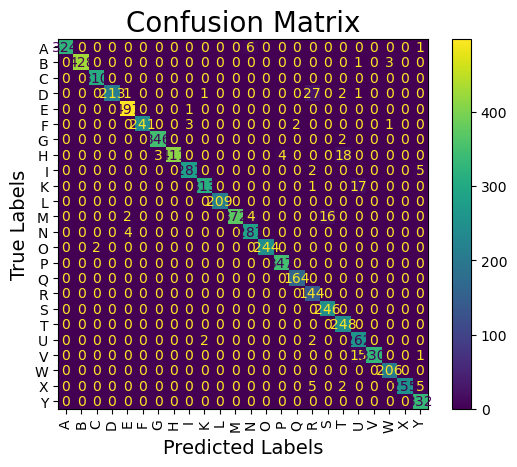

Classification Report:

              precision    recall  f1-score   support

           A       1.00      0.98      0.99       331
           B       1.00      0.99      1.00       432
           C       0.99      1.00      1.00       310
           D       1.00      0.87      0.93       245
           E       0.99      1.00      0.99       498
           F       1.00      0.98      0.99       247
           G       0.99      0.99      0.99       348
           H       1.00      0.94      0.97       436
           I       0.99      0.98      0.98       288
           K       0.99      0.95      0.97       331
           L       1.00      1.00      1.00       209
           M       1.00      0.94      0.97       394
           N       0.97      0.99      0.98       291
           O       1.00      0.99      1.00       246
           P       0.99      1.00      0.99       347
           Q       0.99      1.00      0.99       164
           R       0.80      1.00      0.89       144
   

In [74]:

# -------------------------------
# Predict on Entire Test Dataset
# -------------------------------

# Initialize arrays for true labels and predictions
true_labels = []
predicted_labels = []

# Loop through the test dataset in batches
for images, labels in test_set:
    predictions = model.predict(images)  # Get predictions
    predicted_classes = np.argmax(predictions, axis=1)  # Convert probabilities to class indices
    true_labels.extend(labels)  # Store true labels
    predicted_labels.extend(predicted_classes)  # Store predicted labels

    # Break after processing all test data (important for generators)
    if len(true_labels) >= test_set.samples:
        break

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# -------------------------------
# 1. Confusion Matrix
# -------------------------------

# Compute and display confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(training_set.class_indices.keys()))

# Adjust figure size before plotting
plt.figure(figsize=(10,10))  # Adjust the width and height as needed
disp.plot(cmap='viridis', xticks_rotation='vertical', values_format='d')

# Add title and show plot
plt.title('Confusion Matrix', fontsize=20)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.show()

# -------------------------------
# 2. Classification Report
# -------------------------------
# Generate classification metrics
print("Classification Report:\n")
print(classification_report(true_labels, predicted_labels, target_names=list(training_set.class_indices.keys())))



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


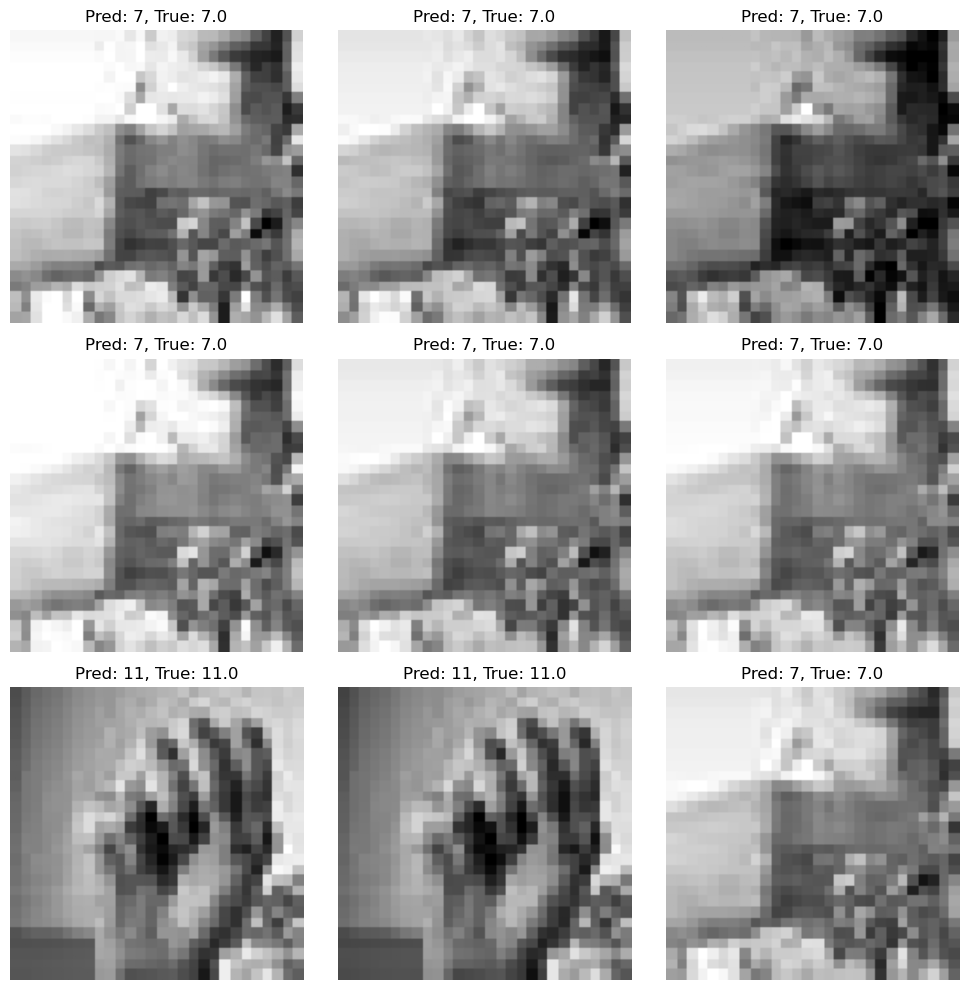

In [75]:
# Display predictions on test images
plt.figure(figsize=(10, 10))
test_images, test_labels = next(test_set)  # Get a batch of test data
predictions = model.predict(test_images)

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i].squeeze(), cmap='gray')
    predicted_label = np.argmax(predictions[i])
    true_label = test_labels[i]
    plt.title(f'Pred: {predicted_label}, True: {true_label}')
    plt.axis('off')
plt.tight_layout()
plt.show()

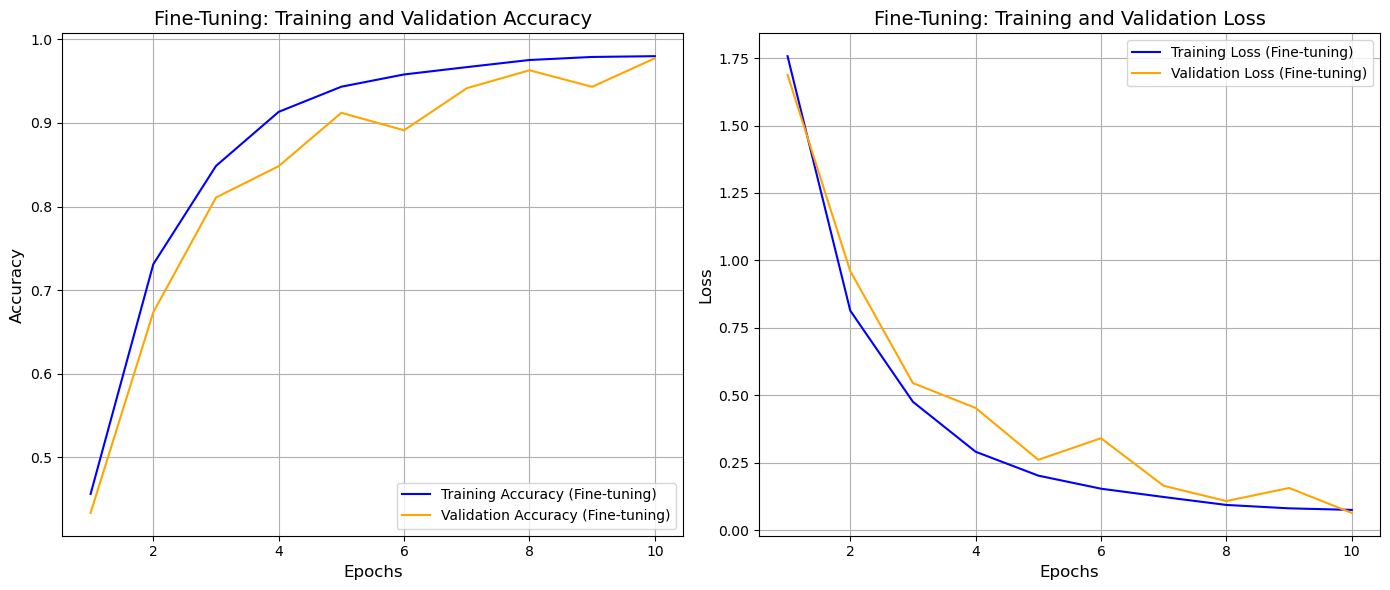

In [76]:
import matplotlib.pyplot as plt

# Assuming 'history_finetune' is the output of the fine-tuning model.fit()
history_finetune_dict = history_finetune.history

# Extract accuracy and loss for training and validation
fine_tune_train_acc = history_finetune_dict['accuracy']
fine_tune_val_acc = history_finetune_dict['val_accuracy']
fine_tune_train_loss = history_finetune_dict['loss']
fine_tune_val_loss = history_finetune_dict['val_loss']

# Define the number of epochs
fine_tune_epochs = range(1, len(fine_tune_train_acc) + 1)

# Set figure size and style
plt.figure(figsize=(14, 6))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(fine_tune_epochs, fine_tune_train_acc, label='Training Accuracy (Fine-tuning)', color='blue')
plt.plot(fine_tune_epochs, fine_tune_val_acc, label='Validation Accuracy (Fine-tuning)', color='orange')
plt.title('Fine-Tuning: Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(fine_tune_epochs, fine_tune_train_loss, label='Training Loss (Fine-tuning)', color='blue')
plt.plot(fine_tune_epochs, fine_tune_val_loss, label='Validation Loss (Fine-tuning)', color='orange')
plt.title('Fine-Tuning: Training and Validation Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

# Show plots
plt.tight_layout()
plt.show()


In [77]:
# Save the model after training
model.save('asl_recognition_model.h5')
print("Model saved to 'asl_recognition_spark_model.h5'.")

Model saved to 'asl_recognition_spark_model.h5'.


In [78]:
# ----------------------
# Step 11: Predict on Outside Data
# ----------------------
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_outside_image(image_path, model, class_indices):
    # Step 1: Load and preprocess the image
    test_image = image.load_img(image_path, target_size=(128, 128), color_mode='rgb')  # Resize to match model input
    test_image = image.img_to_array(test_image) / 255.0  # Normalize to [0, 1]
    test_image = np.expand_dims(test_image, axis=0)      # Add batch dimension

    # Step 2: Predict
    result = model.predict(test_image)
    predicted_class_index = np.argmax(result)

    # Step 3: Map prediction back to class label
    reverse_class_indices = {v: k for k, v in class_indices.items()}
    predicted_label = reverse_class_indices[predicted_class_index]

    # Step 4: Combine class labels and probabilities, then sort and select top 5
    probabilities = {reverse_class_indices[i]: prob for i, prob in enumerate(result[0])}
    top_5_predictions = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)[:5]

    # Step 5: Print the predicted label and top 5 class probabilities
    print(f"Predicted Label: {predicted_label}")
    print("Top 5 Class Probabilities:")
    for label, prob in top_5_predictions:
        print(f"  {label}: {prob:.2f}")

# Example usage
predict_outside_image('archive/Prediction/S.jpg', model, training_set.class_indices)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted Label: S
Top 5 Class Probabilities:
  S: 0.98
  M: 0.01
  N: 0.01
  E: 0.00
  I: 0.00


In [9]:
# ----------------------
# Step 11: Predict on Outside Data
# ----------------------
from tensorflow.keras.preprocessing import image
import numpy as np
from keras.models import load_model

def load_predict_outside_image(image_path, model, class_indices):
    # Step 1: Load and preprocess the image
    test_image = image.load_img(image_path, target_size=(128, 128), color_mode='rgb')  # Resize to match model input
    test_image = image.img_to_array(test_image) / 255.0  # Normalize to [0, 1]
    test_image = np.expand_dims(test_image, axis=0)      # Add batch dimension

    # Step 2: Predict
    result = model.predict(test_image)
    predicted_class_index = np.argmax(result)

    # Step 3: Map prediction back to class label
    reverse_class_indices = {v: k for k, v in class_indices.items()}
    predicted_label = reverse_class_indices[predicted_class_index]

    # Step 4: Combine class labels and probabilities, then sort and select top 5
    probabilities = {reverse_class_indices[i]: prob for i, prob in enumerate(result[0])}
    top_5_predictions = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)[:5]

    # Step 5: Print the predicted label and top 5 class probabilities
    print(f"Predicted Label: {predicted_label}")
    print("Top 5 Class Probabilities:")
    for label, prob in top_5_predictions:
        print(f"  {label}: {prob:.2f}")

model = load_model('asl_recognition_model.h5')

# Example usage
load_predict_outside_image('archive/Prediction/S.jpg', model, training_set.class_indices)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step
Predicted Label: S
Top 5 Class Probabilities:
  S: 0.98
  M: 0.01
  N: 0.01
  E: 0.00
  I: 0.00
